In [20]:
import os
from typing import (
    List,
    Any,
    AsyncGenerator,
    Coroutine,
    Tuple,
    Optional,
    TypedDict,
    Annotated,
    Literal,
)
from IPython.display import display, Image

from dotenv import load_dotenv
from langchain_core.messages import AIMessage, SystemMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.tools import StructuredTool, render_text_description
from langchain_community.tools import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, ValidationError
from sqlalchemy import Row, RowMapping
from langgraph.graph import StateGraph, START, END

from agents.consts import (
    GUIDANCE_PROMPT,
    DISCREPANCY_TEMPLATE,
    SUPERVISOR_TEMPLATE,
    FEEDBACK_TEMPLATE,
    GUIDANCE_TEMPLATE,
)
from agents.llm_callback import CustomLlmTrackerCallback
from db.db import get_session
from db.models import Grade, UserSkills, User, Skill
from service.service import BaseService

In [21]:
load_dotenv()

search = TavilySearchResults()

LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")

custom_callback = CustomLlmTrackerCallback("guidance")

In [22]:
import operator
from langgraph.graph import add_messages


async def find_current_grade_for_user_and_skill(
    user_id: int, skill_id: int
) -> UserSkills:
    """
    Utilize to find current expertise and grading level with user id and skill_id
    :param user_id: users id
    :param skill_id: skill id
    :return:
    """
    async for session in get_session():
        user_skill_service: BaseService[UserSkills, int, Any, Any] = BaseService(
            UserSkills, session
        )
        filters = {
            "user_id": user_id,
            "skill_id": skill_id,
        }
        user_skill = await user_skill_service.list_all(filters=filters)
        if len(user_skill) == 0:
            raise Exception(f"No user_skills found for user_id {user_id}")
        single_user_skill = user_skill[0]
        await single_user_skill.awaitable_attrs.user
        await single_user_skill.awaitable_attrs.skill
        await single_user_skill.awaitable_attrs.grade
        return single_user_skill


class DiscrepancyValues(BaseModel):
    grade_id: int
    skill_id: int
    user_id: int


class GuidanceValue(BaseModel):
    messages: Annotated[list, add_messages]


class SupervisorState(TypedDict):
    discrepancy: DiscrepancyValues
    guidance: GuidanceValue
    next_steps: Annotated[list, operator.add]
    messages: Annotated[list, add_messages]
    chat_messages: Annotated[list, add_messages]


async def discrepancy_agent(state: SupervisorState) -> SupervisorState:
    """
    Discrepancy agent that resolves the discrepancies and explains
    the differences between the grades from saved and now provided stated
    :return: None
    """
    discrepancy_callback = CustomLlmTrackerCallback("discrepancy_agent")
    tools = [
        StructuredTool.from_function(
            function=find_current_grade_for_user_and_skill,
            coroutine=find_current_grade_for_user_and_skill,
        ),
        StructuredTool.from_function(
            function=get_grades_or_expertise,
            coroutine=get_grades_or_expertise,
        ),
    ]
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
        callbacks=[discrepancy_callback],
    )

    prompt_template = ChatPromptTemplate.from_template(DISCREPANCY_TEMPLATE)
    prompt = await prompt_template.ainvoke(
        input={
            "user_id": state["discrepancy"].user_id,
            "skill_id": state["discrepancy"].skill_id,
            "current_grade": state["discrepancy"].grade_id,
        }
    )
    print(f"\n\nDISCREPANCY AGAIN PROMPT\n {prompt}")
    agent = create_react_agent(model=model, tools=tools)
    response = await agent.ainvoke(prompt)
    print(f"\n\nDISCREPANCY AGAIN RESPONSE\n {response}")
    response_msgs = []
    if "messages" in response and len(response["messages"]) > 0:
        response_msgs = [response["messages"][-1].content]
    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": response_msgs,
        "chat_messages": state["chat_messages"],
    }

In [23]:
import re
from langgraph.types import interrupt


async def supervisor_agent(state: SupervisorState) -> SupervisorState:
    prompt_template = ChatPromptTemplate.from_template(SUPERVISOR_TEMPLATE)
    msgs_len = len(state["chat_messages"])
    msgs = []
    for index in range(0, msgs_len, 2):
        question = f"Question: {state["chat_messages"][index].content}"
        answer = f"Answer: {state["chat_messages"][index + 1].content}"
        msgs.extend([question, answer])
    prompt_msgs = "\n".join(msgs)
    scratchpad_msgs = [m.content for m in state["messages"]]
    scratchpad_msgs_str = "\n".join(scratchpad_msgs)
    prompt = await prompt_template.ainvoke(
        {"discussion": prompt_msgs, "agent_scratchpad": scratchpad_msgs_str}
    )
    print(f"\n\nSUPERVISOR AGENT PROMPT\n {prompt}")

    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
        stop=["\nObserve:"],
    )
    response = await model.ainvoke(prompt)
    print(f"\n\nSUPERVISOR AGENT RESPONSE\n {response}")
    content = response.content
    next_steps = []
    match = re.search(r"\nCall: (discrepancy|guidance|feedback)", content)

    if match:
        print("\n\n\nIS MATCHING THIS\n\n\n")
        for val in match.groups():
            next_steps.append(val)
    else:
        next_steps.append("finish")
        print("\n\n\nFINISHHHHHHH\n\n\n")

    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": next_steps,
        "messages": [content],
        "chat_messages": state["chat_messages"],
    }


async def evasion_detector_agent(state: SupervisorState) -> SupervisorState:
    prompt_template = ChatPromptTemplate.from_template(
        """
        From provided discussion, check whether the user is evading to answer a provided question?

        Discussion:
        {}

        Respond in the following format:
        Observe: Your answer
        """
    )
    return state


async def feedback_agent(state: SupervisorState) -> SupervisorState:
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    prompt_template = ChatPromptTemplate.from_messages(
        [SystemMessage(FEEDBACK_TEMPLATE)] + state["messages"]
    )
    prompt = await prompt_template.ainvoke(input={})
    feedback_response = await model.ainvoke(prompt)

    interrupt_val = {
        "answer_to_revisit": "Please provide additional feedback",
    }
    print(f"\n\nFEEDBACK AGENT\n {interrupt_val}")
    print(f"\n\nFEEDBACK RESPONSE\n {feedback_response}")
    value = interrupt(
        interrupt_val,
    )

    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": [interrupt_val],
        "chat_messages": [feedback_response],
    }


async def guidance_agent(state: SupervisorState) -> SupervisorState:
    print("\n\n\nENTERING GUIDANCE\n\n\n")
    tools = [search]
    template = ChatPromptTemplate.from_template(GUIDANCE_TEMPLATE)
    prompt = await template.ainvoke(
        input={
            "tools": render_text_description(tools),
            "context": state["chat_messages"][0].content,
            "answer": state["chat_messages"][-1].content,
        }
    )
    model = ChatOpenAI(
        temperature=0,
        max_tokens=300,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
    )
    print(f"\n\nGUIDANCE AGENT PROMPT\n {prompt}")
    agent = create_react_agent(model=model, tools=tools)
    agent_response = await agent.ainvoke(prompt)
    print(f"\n\nGUIDANCE AGENT RESPONSE\n {agent_response}")
    return {
        "discrepancy": state["discrepancy"],
        "guidance": state["guidance"],
        "next_steps": state["next_steps"],
        "messages": [agent_response["messages"][-1]],
        "chat_messages": state["chat_messages"],
    }


async def finish(state: SupervisorState) -> SupervisorState:
    return state


async def next_step(
    state: SupervisorState,
) -> Literal["guidance", "feedback", "discrepancy", "finish"]:
    if len(state["next_steps"]) > 0:
        if state["next_steps"][-1] == "guidance":
            return "guidance"
        elif state["next_steps"][-1] == "discrepancy":
            return "discrepancy"
        elif state["next_steps"][-1] == "feedback":
            return "feedback"
    return "finish"

In [24]:
class GuidanceHelperStdOutput(BaseModel):
    has_user_answered: bool = Field(
        description="Whether the user has correctly answered the topic at hand"
    )
    expertise_level: str = Field(
        description="The expertise user has self evaluated himself with"
    )
    expertise_id: int = Field(description="The expertise or grade ID")
    is_more_categories_answered: bool = Field(
        description="if multiple categories have been selected", default=False
    )
    should_admin_be_involved: bool = Field(
        description="Whether the admin should be involved if user is evading the topic or fooling around"
    )
    message: str = Field(description="Message to send to the user")


async def get_grades_or_expertise() -> List[Grade]:
    """
    Useful tool to retrieve current grades or expertise level grading system
    :return: List of json representing those grades and all their fields
    """
    async for session in get_session():
        service: BaseService[Grade, int, Any, Any] = BaseService(Grade, session)
        all_db_grades = await service.list_all()
        all_grades_json: List[str] = []
        for grade in all_db_grades:
            json_grade = grade.model_dump_json()
            all_grades_json.append(json_grade)
        return all_grades_json


async def get_current_grade_for_user(
    skill_id: int, user_id: int
) -> None | Row[Any] | RowMapping | Any:
    """
    Useful tool to expertise level or grade for specific skill for a user
    :param skill_id: id of the skill user is looking (ex. Java Development, DevOPS etc...)
    :param user_id: id of the user
    :return: UserSkill explaining the expertise level for specific user and skill
    """
    async for session in get_session():
        service: BaseService[UserSkills, int, Any, Any] = BaseService(
            UserSkills, session
        )
        filters = {
            "skill_id": skill_id,
            "user_id": user_id,
        }
        proper_skill = await service.list_all(filters=filters)
        if len(proper_skill) == 0:
            return None
        return proper_skill[0]


async def is_valid_response_for_guidance(
    chunk: BaseMessage,
) -> Tuple[bool, Optional[AIMessage]]:
    if "agent" in chunk and "messages" in chunk["agent"]:
        msg_content = chunk["agent"]["messages"][-1]
        if isinstance(msg_content, AIMessage) and msg_content.content != "":
            return True, msg_content
    return False, None


async def strip_unnecessary_chars(llm_str: AIMessage) -> str:
    content = llm_str.content
    content = content.replace("```json", "").replace("```", "")
    return content


async def provide_guidance(
    msgs: List[str],
    user: User,
    skill: Skill,
) -> AsyncGenerator[GuidanceHelperStdOutput, Any]:
    model = ChatOpenAI(
        temperature=0,
        model=LITE_MODEL,
        api_key=LITE_LLM_API_KEY,
        base_url=LITE_LLM_URL,
        streaming=True,
        verbose=True,
        callbacks=[custom_callback],
    )
    tools = [
        StructuredTool.from_function(
            function=get_grades_or_expertise,
            coroutine=get_grades_or_expertise,
        ),
        StructuredTool.from_function(
            function=get_current_grade_for_user,
            coroutine=get_current_grade_for_user,
        ),
    ]
    intermediate_steps = []

    system_msg = GUIDANCE_PROMPT
    agent = create_react_agent(model=model, tools=tools)
    async for chunk in agent.astream(
        {
            "messages": [SystemMessage(system_msg)] + msgs,
            "tools": render_text_description(tools),
            "context": msgs[0],
            "intermediate_steps": intermediate_steps,
            "user": user,
            "skill": skill,
        }
    ):
        print("PROVIDE FEEDBACK", chunk)
        (is_valid, msg_content) = is_valid_response_for_guidance(chunk)
        if is_valid:
            content = strip_unnecessary_chars(msg_content)
            try:
                ch = GuidanceHelperStdOutput.model_validate_json(content)
                yield ch
            except ValidationError:
                yield GuidanceHelperStdOutput(
                    has_user_answered=False,
                    expertise_level="",
                    expertise_id=0,
                    should_admin_be_involved=False,
                    message=content,
                )

In [30]:
state_graph = StateGraph(SupervisorState)

state_graph.add_node("supervisor", supervisor_agent)
state_graph.add_node("discrepancy", discrepancy_agent)
state_graph.add_node("guidance", guidance_agent)
state_graph.add_node("feedback", feedback_agent)
state_graph.add_node("finish", finish)
state_graph.add_edge(START, "supervisor")
state_graph.add_conditional_edges("supervisor", next_step)
state_graph.add_edge("discrepancy", "supervisor")
state_graph.add_edge("guidance", "supervisor")
state_graph.add_edge("feedback", "supervisor")
state_graph.add_edge("finish", END)

graph = state_graph.compile()


state_vals = SupervisorState(
    discrepancy=DiscrepancyValues(skill_id=1, user_id=1, grade_id=1),
    guidance=GuidanceValue(messages=[]),
    next_steps=[],
    messages=[],
    chat_messages=[
        AIMessage(
            """
        Expertise Levels in Amazon Web Services
Welcome, Oliver! In this discussion, we will explore the various expertise levels available for Amazon Web Services (AWS). Understanding these levels will help you select the appropriate expertise that aligns with your current knowledge and goals.

Here are the expertise levels you can choose from:

Not Informed: You have no prior knowledge of AWS.
Informed Basics: You have a basic understanding of AWS concepts.
Informed in Details: You are knowledgeable about AWS and its services in detail.
Practice and Lab Examples: You have hands-on experience with AWS through practical examples and labs.
Production Maintenance: You are capable of maintaining AWS services in a production environment.
Production from Scratch: You can set up and manage AWS services from the ground up.
Educator/Expert: You possess extensive knowledge and can teach others about AWS.
Consider your current skills and aspirations as you decide which level best represents your expertise in AWS. Let's dive into the details!
        """
        ),
        HumanMessage(
            """
    Provide comprehensive explanation of AWS Services
    """
        ),
        AIMessage(
            """
        Here is a comprehensive overview of AWS services:\n\nAmazon Web Services (AWS) is a secure cloud services platform that offers a wide range of functionalities to help businesses scale and grow. It provides computing power, database storage, content delivery, and other services, allowing customers to rent IT infrastructure components on-demand. AWS is known for pioneering the Infrastructure-as-a-Service (IaaS) model and currently dominates the public cloud market.\n\n### Core AWS Services\n1. **Compute**: Services like Amazon EC2 (Elastic Compute Cloud) allow users to run virtual servers in the cloud.\n2. **Storage**: Amazon S3 (Simple Storage Service) provides scalable object storage for data backup and archiving.\n3. **Databases**: Amazon RDS (Relational Database Service) offers managed database services for various database engines.\n4. **Networking**: Amazon VPC (Virtual Private Cloud) enables users to create isolated networks within the AWS cloud.\n5. **Analytics**: Services like Amazon Redshift and AWS Glue help in data analysis and processing.\n\nAWS offers over 200 fully featured services across various categories, including analytics, machine learning, security, and more. This versatility allows companies to quickly launch applications without the need to manage physical infrastructure.\n\nFor more detailed information, you can explore the following resources:\n- [AWS Services Overview: Core Components](https://awsforengineers.com/blog/aws-services-overview-core-components/)\n- [Common AWS Services Explained: EC2, RDS, S3, VPC - Spiceworks](https://www.spiceworks.com/tech/big-data/articles/common-aws-services-explained/)\n- [What is AWS? - Cloud Computing with AWS - Amazon Web Services](https://aws.amazon.com/what-is-aws/)\n\nFeel free to ask if you have any specific questions about AWS services!
        """
        ),
        HumanMessage(
            """
        What is the difference between production from scratch and educator?
        """
        ),
        # AIMessage("""
        # The difference between "Production from Scratch" and "Educator" in AWS expertise levels is as follows:\n\n- **Production from Scratch**: This level indicates that you can set up and manage AWS services from the ground up. It involves a comprehensive understanding of AWS services and the ability to deploy and configure them effectively in a production environment.\n\n- **Educator/Expert**: This level signifies that you possess extensive knowledge of AWS and can teach others about it. It implies a deep understanding of AWS concepts, services, and best practices, along with the ability to convey that knowledge to others.\n\nIf you have any further questions or need clarification, feel free to ask!
        # """),
        # HumanMessage("""
        # I'm not informed
        # """)
    ],
)

async for chunk in graph.astream(state_vals):
    print(chunk)



SUPERVISOR AGENT PROMPT
 messages=[HumanMessage(content="\n        You are supervising multiple agents doing their job. You distribute the tasks to them to solve the problem stated in the discussion (Question and Answer).\n        When the user has clearly identified itself with specific grade or expertise level provide a Finish Answer!\n        You have the following agents at your disposal:\n        discrepancy -> agent that finds the discrepancies between submitted expertise and the one saved within the database\n        guidance -> agent that helps the user and answers his questions when he asks questions. Does not provide guidance on further learning and additional clarification, only answers the questions that user asked\n        feedback -> agent that asks user for further clarifications and or additional input.\n        Take note of evasion of topic from user, and please notify the user that the admin and managers can be involved if it happens 4 or 5 times!\n    \n        Do 

In [26]:
response = await guidance_agent(state_vals)
print(response)




ENTERING GUIDANCE





GUIDANCE AGENT PROMPT
 messages=[HumanMessage(content="\n        You are helping the user to properly grade their expertise in the mentioned field. You can find the explanation\n        about the topic in topic.\n        User has provided answer within answer!\n        Everything you help him with should be done by utilizing the tools or explaining the topics mentioned in the context\n        of helping him populate his expertise level on the topic.\n        Tools:\n        tavily_search_results_json - A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.\n        Do not discuss anything except from the provided context, but answer to the user if the question is regarding anything from context!\n        Warn the user if answering with unrelated topics or evading to answer the question will be escalated by involving managers!\n        Topic:\

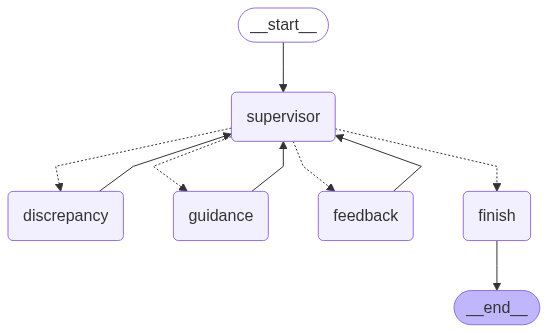

In [31]:
display(Image(graph.get_graph().draw_mermaid_png()))